In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
from fastcore.xtras import load_pickle

import matplotx
import numpy as np
import pandas as pd

from gptchem.plotsettings import *

%matplotlib inline

In [16]:
all_res = glob("out/**/*.pkl")

In [17]:
compiled_res = []
compiled_gpr = []

for res in all_res:
    loaded = load_pickle(res)
    repre = loaded["representation"]
    num_points = loaded["num_train_points"]

    metrics = {
        "representation": loaded["representation"],
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["mean_absolute_error"],
        "max_error": loaded["max_error"],
        "mse": loaded["mean_squared_error"],
    }

    compiled_res.append(metrics)

    gpr_metrics = {
        "num_train_points": loaded["num_train_points"],
        "mae": loaded["gpr_baseline"]["mean_absolute_error"],
        "max_error": loaded["gpr_baseline"]["max_error"],
        "mse": loaded["gpr_baseline"]["mean_squared_error"],
    }

    compiled_gpr.append(gpr_metrics)

In [18]:
compiled_res = pd.DataFrame(compiled_res)
compiled_gpr = pd.DataFrame(compiled_gpr)

In [19]:
compiled_grouped_res = compiled_res.groupby(["representation", "num_train_points"]).agg(
    ["mean", "std"]
)

In [20]:
compiled_gpr_grouped = compiled_gpr.groupby(["num_train_points"]).agg(["mean", "std"])

In [21]:
compiled_grouped_res

mae           max_error            \
                                     mean       std      mean       std   
representation num_train_points                                           
InChI          10                2.590600  0.606471  7.880000  1.173797   
               50                2.419744  0.186182  7.872000  0.648591   
               100               2.296072  0.159767  8.150000  0.586686   
               200               2.171624  0.141248  7.624000  0.908532   
               500               2.048170  0.047283  7.425000  0.765485   
SELFIES        10                1.995320       NaN  6.790000       NaN   
               50                2.270780  0.070047  8.048333  0.497209   
               100               2.328747  0.161490  8.460000  0.285867   
               200               2.246552  0.019912  8.268000  0.520452   
               500               2.153880  0.083308  8.038000  0.814844   
SMILES         10                2.490267  0.389636  7.413333  1.042617   
               50                2.468225  0.262436  7.958750  1.270741   
               100               2.360893  0.224988  7.924444  0.769807   
               200               2.117711  0.070789  8.033333  0.504331   
               500               1.990114  0.100678  7.135714  0.704340   

                                      mse            
                                     mean       std  
representation num_train_points                      
InChI          10                9.717969  4.439513  
               50                8.729042  1.241121  
               100               8.192075  1.147401  
               200               7.355268  1.128255  
               500               6.682002  0.483866  
SELFIES        10                6.026665       NaN  
               50                7.925279  0.665553  
               100               8.468544  1.310805  
               200               7.856587  0.195403  
               500               7.467592  0.425018  
SMILES         10                9.119594  2.660080  
               50                9.155260  1.885829  
               100               8.502304  1.684312  
               200               7.049765  0.425937  
               500               6.388704  0.816250

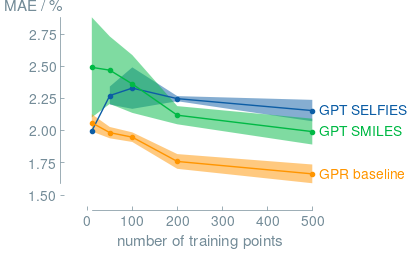

In [29]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(1, 1)
ax.plot(
    compiled_grouped_res.loc["SELFIES", :].index,
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"],
    label="GPT SELFIES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["SELFIES", :].index,
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"]
    - compiled_grouped_res.loc["SELFIES", :]["mae"]["std"],
    compiled_grouped_res.loc["SELFIES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SELFIES", :]["mae"]["std"],
    alpha=.5
)

ax.plot(
    compiled_grouped_res.loc["SMILES", :].index,
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"],
    label="GPT SMILES",
    marker="o",
)

ax.fill_between(
    compiled_grouped_res.loc["SMILES", :].index,
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    - compiled_grouped_res.loc["SMILES", :]["mae"]["std"],
    compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SMILES", :]["mae"]["std"],
    alpha=0.5,
)

ax.plot(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped["mae"]["mean"],
    label="GPR baseline",
    marker="o",
)

ax.fill_between(
    compiled_gpr_grouped.loc[:].index,
    compiled_gpr_grouped.loc[:]["mae"]["mean"] - compiled_gpr_grouped.loc[:]["mae"]["std"],
    compiled_gpr_grouped.loc[:]["mae"]["mean"] + compiled_gpr_grouped.loc[:]["mae"]["std"],
    alpha=0.5,
)

matplotx.line_labels()

ax.set_xlabel("number of training points", labelpad=4)
ylabel_top("MAE / \%", y_pad=-0.05, x_pad=0.02)
# ax.set_xscale('log')

range_frame(
    ax, 
     compiled_gpr_grouped.loc[:].index,
     np.stack(
        [    compiled_gpr_grouped.loc[:]["mae"]["mean"] - compiled_gpr_grouped.loc[:]["mae"]["std"], 
        compiled_grouped_res.loc["SMILES", :]["mae"]["mean"]
    + compiled_grouped_res.loc["SMILES", :]["mae"]["std"]
        ]
     ).flatten(), 0.08
)

fig.savefig("opv_regression_res.pdf", bbox_inches="tight")